# Mutual Information

Mutual Information can be used for features selection. It is a great way of detecting non-linear relationship between
input and output of the data.

```
feature_selection.mutual_info_classif(X, y)	Estimate mutual information for a discrete target variable.
feature_selection.mutual_info_regression(X, y)	Estimate mutual information for a continuous target variable.
```

Have joint pmf -> be able to sum out certain variables to get the pmf for the variable alone.


$I(X,Y) = H(X) + H(Y) - H(X,Y)$




In [2]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, chi2
from sklearn.preprocessing import OneHotEncoder

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import pshape
from matplotlib import colors
from utils.plots import plot_dist

In [4]:
def plot_mi(mi):
    figsize=(20,5)
    plt.figure(figsize=figsize)
    plt.imshow(np.array([mi]),aspect=20*figsize[1]/figsize[0], vmin=0,vmax=np.max(mi))
    plt.colorbar()
    plt.show()
    
def plot_mi_r(X,y):
    print("mi_r")
    plot_mi(mutual_info_regression(X,y))

def plot_mi_c(X,y):
    print("mi_c")
    plot_mi(mutual_info_classif(X,y))    

In [5]:
def dist(a, plot=True):

    v,c = np.unique(a.flatten(),return_counts=True)
    c = c/np.sum(c)

    if plot:
        plt.stem(v,c, use_line_collection=True,markerfmt="x",basefmt=".")
        plt.grid()
        plt.show()
    
    return v,c

def dists(*args):
    for a in args:
        _ = dist(a)

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
mi_c


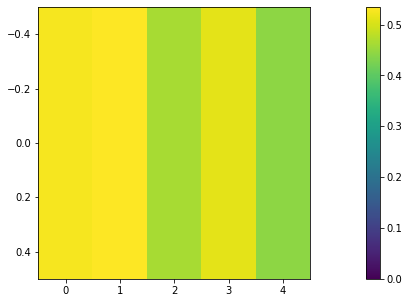

mi_r


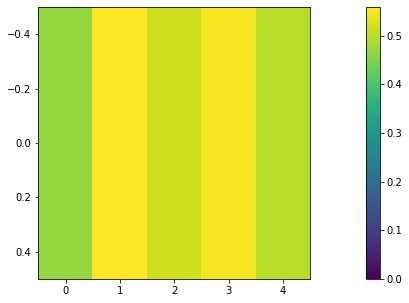

In [6]:
num = np.random.randint(5,size=(1000,1))
enc = OneHotEncoder(sparse=False,categories='auto')
X = enc.fit_transform(num)
y = np.argmax(X,axis=1)


print(X)
# mask = np.logical_or(y == 3, y == 1)
# y = y[mask]
# X = X[mask]

plot_mi_c(X,y)
plot_mi_r(X,y)

In [7]:
# squeeze into (N,1,L)
# get MI for each L give the past n steps.



In [8]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer, get_data_sub_paths, pshape, get_data_resolutions
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.cell_loader import CellDataLoaders
from datasets.cell_dataset import CellDataGroup

from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn
from utils.configs import BaseConf
from utils.metrics import best_threshold, get_y_pred
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models,\
                                get_models_metrics, get_models_results
from pprint import pprint
from time import time

In [257]:
data_sub_paths = get_data_sub_paths()
pprint(np.sort(data_sub_paths))

# data_sub_path = 'T12H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01'
# data_sub_path = 'T1H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X255M-Y220M_2013-01-01_2015-01-01'
data_sub_path = 'T24H-X425M-Y440M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T24H-X850M-Y880M_2013-01-01_2017-01-01'
# data_sub_path = 'T24H-X85M-Y110M_2013-01-01_2015-01-01'
# data_sub_path = 'T3H-X850M-Y880M_2013-01-01_2015-01-01'
# data_sub_path = 'T6H-X850M-Y880M_2013-01-01_2015-01-01

array(['T12H-X850M-Y880M_2013-01-01_2015-01-01',
       'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
       'T1H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X255M-Y220M_2013-01-01_2015-01-01',
       'T24H-X425M-Y440M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2015-01-01',
       'T24H-X850M-Y880M_2013-01-01_2017-01-01',
       'T24H-X85M-Y110M_2013-01-01_2015-01-01',
       'T3H-X850M-Y880M_2013-01-01_2015-01-01',
       'T6H-X850M-Y880M_2013-01-01_2015-01-01'], dtype='<U39')


In [258]:
conf = BaseConf()

conf.use_historic_average = True 
conf.use_classification = True
conf.use_crime_types = True

conf.seed = 3#int(time())  # idea is to have a constant seed while changing hyper parameters

conf.pad_with = 1 
conf.seq_len = 1

conf.model_name = f"Mutual Info"

conf.data_path = f"./data/processed/{data_sub_path}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path,
              log_config='./logger/standard_logger_config.json',
              default_level=log.INFO)

# SET NUMPY AND TORCH SEEDS LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")

conf.device = device

# SET THE HYPER PARAMETERS
conf.resume = False
conf.early_stopping = False
conf.max_epochs = 120
conf.dropout = 0#0.2
conf.weight_decay = 0#1e-8
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 4e-3
conf.batch_size = 64

# CRIME DATA
conf.sub_sample_test_set = 0
conf.sub_sample_train_set =  1 # 0 #
conf.sub_sample_validation_set = 1 # 0 #


2019-11-30T17:32:54 | root | INFO | Device: cpu


In [ ]:

data_group = CellDataGroup(data_path=conf.data_path, conf=conf)
loaders = CellDataLoaders(data_group=data_group, conf=conf)
conf.freqstr = data_group.t_range.freqstr  

In [11]:
crimes = data_group.crimes[:,0] # select only totals
targets = data_group.targets[:,0] # remove channel 1

pshape(crimes,targets)

(1460, 704)
(1460, 704)


In [ ]:
mi = mutual_info_classif(tmp_feats,targets[:,0])#,discrete_features=True)
# mi = mutual_info_regression(X,y)
mi = mi/np.max(mi)

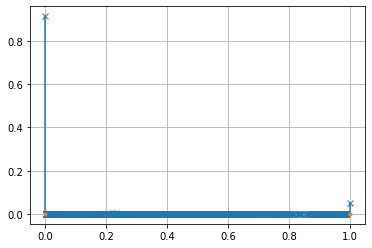

{'dist': {0.0: 0.9146868875805046,
          0.001741771318336056: 7.439369141496801e-08,
          0.0017483940229685124: 7.439369141496801e-08,
          0.001755067282598163: 7.439369141496801e-08,
          0.00176179167831693: 7.439369141496801e-08,
          0.001765173236240763: 1.0627670202138287e-08,
          0.0017685678001566106: 8.50213616171063e-08,
          0.0017719754452436174: 1.0627670202138287e-08,
          0.0017753962472614624: 8.50213616171063e-08,
          0.001778830282555972: 1.0627670202138287e-08,
          0.0017822776280648014: 8.50213616171063e-08,
          0.0017857383613231795: 1.0627670202138287e-08,
          0.0017892125604697228: 8.50213616171063e-08,
          0.0017927003042523147: 1.0627670202138287e-08,
          0.0017962016720340576: 8.50213616171063e-08,
          0.0017997167437992906: 1.0627670202138287e-08,
          0.0018032456001596815: 8.50213616171063e-08,
          0.0018067883223603879: 1.0627670202138287e-08,
          0.001810

          0.0055880162824458735: 1.0627670202138287e-08,
          0.005588182979661513: 3.188301060641486e-08,
          0.005595032809156798: 3.188301060641486e-08,
          0.0055962794487714245: 6.376602121282972e-08,
          0.0055969458178256725: 1.0627670202138287e-08,
          0.005597503576643575: 1.0627670202138287e-08,
          0.005597901558756576: 3.188301060641486e-08,
          0.005606779128683084: 2.1255340404276573e-08,
          0.0056070231405494315: 1.0627670202138287e-08,
          0.0056072490379977516: 3.188301060641486e-08,
          0.005607310532303128: 1.0627670202138287e-08,
          0.005607654000496571: 9.671179883945842e-07,
          0.0056165751390852905: 1.0627670202138287e-08,
          0.005617440482172829: 3.188301060641486e-08,
          0.005617713705832447: 1.0627670202138287e-08,
          0.005619074884407969: 6.376602121282972e-08,
          0.005619518729546981: 3.188301060641486e-08,
          0.005626159738298746: 1.0627670202138287e

          0.007061901508989493: 1.0627670202138287e-08,
          0.007062199065471789: 6.376602121282972e-08,
          0.007063190018535008: 1.0627670202138287e-08,
          0.007074271200626443: 1.6154058707250197e-06,
          0.007074527402192368: 1.0627670202138287e-08,
          0.0070745572464608: 1.0627670202138287e-08,
          0.00707459496041462: 2.1255340404276573e-08,
          0.0070749562374314715: 4.251068080855315e-08,
          0.007075820846991216: 3.188301060641486e-08,
          0.007085901240459558: 1.0627670202138287e-08,
          0.007086384678709707: 6.376602121282972e-08,
          0.007087258426436493: 1.0627670202138287e-08,
          0.00708790178097447: 7.439369141496801e-08,
          0.007088974218464243: 2.1255340404276573e-08,
          0.0070898532957820075: 1.3815971262779774e-07,
          0.007097311709445805: 1.0627670202138287e-08,
          0.007098539712463926: 6.376602121282972e-08,
          0.007100005294109939: 1.0627670202138287e-08,


          0.009114715729600308: 2.1255340404276573e-08,
          0.00911552566600544: 8.50213616171063e-08,
          0.009120547994196076: 6.376602121282972e-08,
          0.00912172230761521: 4.251068080855315e-08,
          0.00912356404842696: 3.507131166705635e-07,
          0.00912511505500175: 2.1255340404276573e-08,
          0.009126807062174249: 2.1255340404276573e-08,
          0.00913015145929225: 4.251068080855315e-08,
          0.009131816509580795: 2.1255340404276573e-08,
          0.009135648239219578: 4.4636214848980807e-07,
          0.009137368486530503: 4.251068080855315e-08,
          0.009141702346733971: 9.564903181924458e-08,
          0.009143362886775492: 2.1255340404276573e-08,
          0.009144046828974782: 2.1255340404276573e-08,
          0.009146661678929306: 5.3138351010691434e-08,
          0.009148981578207828: 2.1255340404276573e-08,
          0.009150798567974502: 1.9129806363848916e-07,
          0.009153068432383647: 4.251068080855315e-08,
      

          0.010995878061843274: 1.3815971262779774e-07,
          0.010997783598113944: 3.188301060641486e-08,
          0.010998372845408865: 1.0627670202138287e-08,
          0.011000660957911933: 2.444364146491806e-07,
          0.011001736607771866: 1.0627670202138287e-08,
          0.011003845527290872: 1.0627670202138287e-08,
          0.011004421867641133: 1.0627670202138287e-08,
          0.011005899771118648: 6.376602121282972e-08,
          0.011006288856297461: 1.0627670202138287e-08,
          0.011006375676957196: 1.0627670202138287e-08,
          0.011008598855407977: 1.0627670202138287e-08,
          0.011008764575560487: 3.188301060641486e-08,
          0.011010718863431596: 2.1255340404276573e-08,
          0.011012428098143578: 2.1255340404276573e-08,
          0.011013835402172906: 2.9757476565987203e-07,
          0.011017180041849595: 3.188301060641486e-08,
          0.011018233898739268: 3.188301060641486e-08,
          0.011019834223198053: 1.3815971262779774e-07

          0.01221848853023288: 1.0627670202138287e-08,
          0.012221332306730066: 5.3138351010691434e-08,
          0.012221512768991787: 1.0627670202138287e-08,
          0.012224456369180662: 7.439369141496801e-08,
          0.012224542238216674: 2.1255340404276573e-08,
          0.012224621018626822: 1.0627670202138287e-08,
          0.012224760556892287: 1.0627670202138287e-08,
          0.012229143140014144: 3.188301060641486e-08,
          0.012229345289778426: 2.1255340404276573e-08,
          0.012229458192572307: 3.0820243586201035e-07,
          0.012233805210999526: 1.0627670202138287e-08,
          0.012234489335492604: 2.1255340404276573e-08,
          0.01223488145562888: 5.3138351010691434e-08,
          0.012237808124506692: 1.0627670202138287e-08,
          0.01223826407257197: 2.1255340404276573e-08,
          0.012238758160779586: 2.444364146491806e-07,
          0.012241129964447635: 1.0627670202138287e-08,
          0.012241667302248753: 5.3138351010691434e-08

          0.013660213081930692: 4.251068080855315e-08,
          0.013660213081930694: 1.0627670202138287e-08,
          0.013662496267595563: 5.3138351010691434e-08,
          0.0136662057284829: 6.376602121282972e-08,
          0.013667068042743504: 2.1255340404276573e-08,
          0.013667912510764465: 4.251068080855315e-08,
          0.01366797474082635: 1.0627670202138287e-08,
          0.013668929339939984: 1.0627670202138287e-08,
          0.013669017688684289: 2.1255340404276573e-08,
          0.01367435927183465: 1.0627670202138287e-08,
          0.01367517109414777: 4.251068080855315e-08,
          0.013676328892767478: 3.188301060641486e-08,
          0.0136775502568016: 3.188301060641486e-08,
          0.013679082756360055: 7.439369141496801e-08,
          0.013680821991294112: 3.188301060641486e-08,
          0.013681982395755658: 2.1255340404276573e-08,
          0.013683199111005637: 1.0627670202138287e-08,
          0.013685346072640438: 3.1883010606414863e-07,
       

          0.015020966179817241: 2.1255340404276573e-08,
          0.015021592204596982: 4.251068080855315e-08,
          0.015024417132910016: 1.0627670202138287e-08,
          0.015027038696206783: 1.0627670202138287e-08,
          0.015027046667997345: 5.632665207133292e-07,
          0.0150298356800959: 4.251068080855315e-08,
          0.015030150519021146: 1.0627670202138287e-08,
          0.015031910488123839: 2.1255340404276573e-08,
          0.015032826301331192: 7.439369141496801e-08,
          0.015033514290881069: 6.376602121282972e-08,
          0.015034569035013408: 3.188301060641486e-08,
          0.015037149577958384: 2.1255340404276573e-08,
          0.015037392311142267: 7.439369141496801e-08,
          0.015041090636845939: 1.5941505303207431e-07,
          0.015041861869528356: 5.3138351010691434e-08,
          0.0150424251589278: 6.376602121282972e-08,
          0.015045484762068509: 5.3138351010691434e-08,
          0.015045562013965341: 3.188301060641486e-08,
     

          0.016291797728078743: 1.0627670202138287e-08,
          0.01629310493057665: 2.338087444470423e-07,
          0.016293643517803495: 4.251068080855315e-08,
          0.016295350358655716: 4.251068080855315e-08,
          0.016298015492917796: 4.251068080855315e-08,
          0.016299859949204583: 3.188301060641486e-08,
          0.01629998026568086: 2.1255340404276573e-08,
          0.0163025233788137: 5.3138351010691434e-08,
          0.016305183785070957: 1.0627670202138287e-08,
          0.016305654076775294: 1.0627670202138287e-08,
          0.016305722611747283: 2.1255340404276573e-08,
          0.01630594425676308: 4.782451590962229e-07,
          0.016308929816664722: 3.188301060641486e-08,
          0.016310950443606156: 2.1255340404276573e-08,
          0.016311453021714686: 3.188301060641486e-08,
          0.016312408857541844: 7.439369141496801e-08,
          0.01631317527417184: 6.376602121282972e-08,
          0.01631396699208852: 1.0627670202138287e-08,
         

          0.017407732526702902: 2.1255340404276573e-08,
          0.017408777214533603: 2.1255340404276573e-08,
          0.017409954736508283: 9.564903181924458e-08,
          0.017411470246234875: 5.3138351010691434e-08,
          0.01741291597904293: 3.188301060641486e-08,
          0.017414161715944773: 1.0627670202138287e-08,
          0.01741545746418209: 1.0627670202138287e-08,
          0.01741771318336056: 6.801708929368504e-07,
          0.017419162189502964: 3.188301060641486e-08,
          0.017420674195912433: 1.0627670202138287e-07,
          0.0174234521333386: 5.3138351010691434e-08,
          0.017423904391423568: 5.3138351010691434e-08,
          0.017424814993448303: 2.1255340404276573e-08,
          0.0174250469573325: 4.251068080855315e-08,
          0.01742622910641683: 2.1255340404276573e-08,
          0.017426835335973265: 5.3138351010691434e-08,
          0.017428710567439852: 2.1255340404276573e-08,
          0.01743028914955793: 3.188301060641486e-08,
       

          0.018666122829838053: 4.251068080855315e-08,
          0.018666700074221537: 1.0627670202138287e-08,
          0.018667462760283873: 1.0627670202138287e-08,
          0.01866821566831978: 3.188301060641486e-08,
          0.018669693254464992: 6.376602121282972e-08,
          0.018670959756875178: 1.0627670202138287e-08,
          0.01867205739229734: 1.0627670202138287e-08,
          0.018673203169166243: 2.1255340404276573e-07,
          0.018674484055176892: 3.188301060641486e-08,
          0.0186755532693468: 1.0627670202138287e-07,
          0.018676459276657113: 1.0627670202138287e-08,
          0.018677717966837704: 4.251068080855315e-08,
          0.0186783988059266: 7.439369141496801e-08,
          0.018683741094205276: 4.251068080855315e-08,
          0.018684039111977246: 4.251068080855315e-08,
          0.018684292512885083: 2.1255340404276573e-08,
          0.01868557499105394: 4.251068080855315e-08,
          0.018685694201944835: 5.3138351010691434e-08,
        

          0.020139209634692033: 3.188301060641486e-08,
          0.020139435063859044: 5.3138351010691434e-08,
          0.020140831344515952: 7.439369141496801e-08,
          0.020144829418926726: 2.1255340404276573e-08,
          0.020144987363385863: 2.1255340404276573e-08,
          0.020146392801369727: 1.0627670202138287e-08,
          0.02014699519457054: 5.3138351010691434e-08,
          0.020150777689447483: 1.0627670202138287e-08,
          0.020151238845234627: 1.0627670202138287e-08,
          0.020151808400190863: 1.5941505303207431e-07,
          0.02015478239788865: 2.1255340404276573e-08,
          0.020158024840401315: 2.1255340404276573e-08,
          0.02015945759677473: 3.188301060641486e-08,
          0.02016055095655727: 7.439369141496801e-08,
          0.02016062771590871: 1.0627670202138287e-08,
          0.020161076440233874: 3.188301060641486e-08,
          0.020162366893853062: 2.1255340404276573e-08,
          0.020165416963291626: 6.376602121282972e-08,
   

          0.02122378488124386: 1.0627670202138287e-08,
          0.0212241327223386: 8.50213616171063e-08,
          0.021224291505356842: 1.0627670202138287e-08,
          0.02122566384430025: 2.1255340404276573e-08,
          0.02123407836493765: 1.0627670202138287e-08,
          0.021234500007010503: 4.251068080855315e-08,
          0.02123537891484669: 1.0627670202138287e-08,
          0.021235381175801694: 1.0627670202138287e-08,
          0.021235871155626976: 7.439369141496801e-08,
          0.02123690522860944: 1.0627670202138287e-08,
          0.021237018965736005: 3.188301060641486e-08,
          0.02123760682228055: 2.1255340404276573e-08,
          0.021238011167667905: 1.0627670202138287e-08,
          0.021238216723445513: 1.0627670202138287e-08,
          0.021239151410656756: 3.188301060641486e-08,
          0.021246161031584363: 1.0627670202138287e-08,
          0.02124678036230952: 8.50213616171063e-08,
          0.021247418652138503: 4.251068080855315e-08,
          

          0.021934301875596078: 1.0627670202138287e-08,
          0.02193524020688941: 4.251068080855315e-08,
          0.021935693808078034: 7.439369141496801e-08,
          0.021935693808078038: 1.0627670202138287e-08,
          0.021936730879006768: 2.1255340404276573e-08,
          0.021937112908740754: 1.0627670202138287e-08,
          0.021938341032477042: 3.188301060641486e-08,
          0.021938681496296623: 1.0627670202138287e-08,
          0.021939472851429394: 1.0627670202138287e-08,
          0.02194008563216153: 8.50213616171063e-08,
          0.021941649909012238: 6.376602121282972e-08,
          0.021941908278032614: 1.0627670202138287e-08,
          0.021941982250905667: 7.439369141496801e-08,
          0.021942213166482295: 1.0627670202138287e-08,
          0.021943498337795495: 2.1255340404276573e-08,
          0.0219440516635484: 5.3138351010691434e-08,
          0.021944210767431065: 1.0627670202138287e-08,
          0.021945203938233186: 7.439369141496801e-08,
    

          0.022806903448242658: 4.251068080855315e-08,
          0.02280745035081965: 2.1255340404276573e-08,
          0.022808910121067397: 7.439369141496801e-08,
          0.022809591888353183: 1.0627670202138287e-08,
          0.02281145820329741: 1.0627670202138287e-08,
          0.022811768247635228: 2.1255340404276573e-08,
          0.022813539345861118: 7.439369141496801e-08,
          0.022814072067011918: 3.188301060641486e-08,
          0.02281587467377612: 1.3815971262779774e-07,
          0.022816924386332114: 7.439369141496801e-08,
          0.02281701765543562: 1.0627670202138287e-08,
          0.022817376729571705: 3.188301060641486e-08,
          0.022818514124422696: 1.1690437222352115e-07,
          0.0228185141244227: 1.0627670202138287e-08,
          0.022819660950408438: 1.0627670202138287e-08,
          0.02281971441725608: 3.188301060641486e-08,
          0.02282012234783991: 2.1255340404276573e-08,
          0.02282127213120511: 1.0627670202138287e-08,
        

          0.02333750502493301: 2.1255340404276573e-08,
          0.023338490952587804: 1.0627670202138287e-08,
          0.023339296928825512: 1.0627670202138287e-08,
          0.023341503961457805: 3.0820243586201035e-07,
          0.023342604405193146: 7.439369141496801e-08,
          0.023343310553127546: 1.0627670202138287e-08,
          0.02334331055312755: 4.251068080855315e-08,
          0.023344661211795254: 4.251068080855315e-08,
          0.02334654599457246: 7.439369141496801e-08,
          0.02334663499882682: 4.251068080855315e-08,
          0.023346656611338924: 6.376602121282972e-08,
          0.02334832652344412: 2.1255340404276573e-08,
          0.023348737990200177: 3.188301060641486e-08,
          0.023349900946079832: 4.251068080855315e-08,
          0.02335062173644275: 9.564903181924458e-08,
          0.023350627498465004: 1.0627670202138287e-08,
          0.023352303116742877: 1.0627670202138287e-08,
          0.02335230311674288: 2.1255340404276573e-08,
        

          0.024063872165172667: 1.0627670202138287e-08,
          0.024063976866649732: 5.3138351010691434e-08,
          0.024065179610533324: 2.1255340404276573e-08,
          0.02406549937110922: 2.1255340404276573e-08,
          0.024065745018953505: 4.251068080855315e-08,
          0.024067309078833442: 5.3138351010691434e-08,
          0.024067772776573043: 1.0627670202138287e-08,
          0.02406821445238602: 1.0627670202138287e-08,
          0.024068933351610592: 6.376602121282972e-08,
          0.02406910858858778: 1.0627670202138287e-08,
          0.024070399301770476: 4.251068080855315e-08,
          0.024070749655641016: 1.5941505303207431e-07,
          0.024072219975833215: 1.0627670202138287e-08,
          0.02407221997583322: 3.188301060641486e-08,
          0.024073544879742677: 4.251068080855315e-08,
          0.02407474492359784: 2.9757476565987203e-07,
          0.024075609508054988: 2.1255340404276573e-08,
          0.024076784006502153: 2.1255340404276573e-08,
  

          0.024863533072338444: 4.251068080855315e-08,
          0.024868273194184727: 1.0627670202138287e-08,
          0.02486842776899049: 1.0627670202138287e-08,
          0.024869171766901135: 2.1255340404276573e-08,
          0.024870170260292906: 6.376602121282972e-08,
          0.024871231129997614: 4.251068080855315e-08,
          0.024871412208207374: 2.1255340404276573e-08,
          0.024872457970861194: 5.3138351010691434e-08,
          0.02487389303700896: 7.439369141496801e-08,
          0.024874086305931298: 1.0627670202138287e-08,
          0.024874534525346922: 2.1255340404276573e-08,
          0.024875920861219213: 2.1255340404276573e-08,
          0.024876443995299938: 1.0627670202138287e-08,
          0.024876580623160467: 1.0627670202138287e-08,
          0.0248772364210511: 2.1255340404276573e-08,
          0.02487809763480861: 1.0627670202138287e-08,
          0.024878733606680678: 6.376602121282972e-08,
          0.024879186984660823: 1.0627670202138287e-08,
  

          0.02541687338086088: 2.1255340404276573e-08,
          0.025417607580140233: 2.444364146491806e-07,
          0.025418670369041527: 1.0627670202138287e-08,
          0.025419494742081727: 4.251068080855315e-08,
          0.02542074655950292: 4.251068080855315e-08,
          0.025421364802251118: 2.1255340404276573e-08,
          0.025423235232384097: 1.0627670202138287e-08,
          0.025423898461004835: 8.50213616171063e-08,
          0.02542439411608814: 2.1255340404276573e-08,
          0.02542693128121753: 9.564903181924458e-08,
          0.02542739416119244: 1.0627670202138287e-08,
          0.02542748406672603: 1.0627670202138287e-08,
          0.02542762554901347: 1.0627670202138287e-08,
          0.025428005854916298: 3.188301060641486e-08,
          0.025428255928519012: 2.1255340404276573e-07,
          0.025431448592450286: 1.0627670202138287e-08,
          0.025431845859712365: 2.1255340404276573e-08,
          0.025432492639211175: 3.188301060641486e-08,
       

          0.02609559810027019: 3.188301060641486e-08,
          0.026095598100270193: 8.50213616171063e-08,
          0.02609589278508971: 5.3138351010691434e-08,
          0.026097207178029557: 1.0627670202138287e-08,
          0.026099108561670383: 1.0627670202138287e-08,
          0.02609944007468885: 6.376602121282972e-08,
          0.026099854172066953: 2.1255340404276573e-08,
          0.026100125521166893: 2.1255340404276573e-08,
          0.026100399588287877: 1.0627670202138287e-08,
          0.026102997305549044: 1.4878738282993601e-07,
          0.026103296753657558: 3.188301060641486e-08,
          0.026103372102856223: 2.1255340404276573e-08,
          0.02610337210285623: 1.0627670202138287e-08,
          0.026103599331885673: 2.1255340404276573e-08,
          0.026103751810171806: 1.9129806363848916e-07,
          0.026105851382462682: 1.0627670202138287e-08,
          0.026107090491111682: 1.0627670202138287e-08,
          0.026107090491111686: 1.0627670202138287e-08,
 

          0.026920927381245463: 1.0627670202138287e-08,
          0.026921447643517952: 4.251068080855315e-08,
          0.026924475218711143: 4.251068080855315e-08,
          0.02692502971868527: 1.0627670202138287e-08,
          0.02692560811952034: 1.0627670202138287e-08,
          0.026925608119520345: 1.2753204242565944e-07,
          0.026926212000568422: 6.376602121282972e-08,
          0.02692684308346551: 2.763194252555955e-07,
          0.02692931102789722: 1.0627670202138287e-08,
          0.026929957994798664: 1.0627670202138287e-08,
          0.026930632433755375: 5.3138351010691434e-08,
          0.026931336132536673: 6.376602121282972e-08,
          0.026932627918798514: 3.188301060641486e-08,
          0.026933305792791844: 4.251068080855315e-08,
          0.026934010890640316: 1.0627670202138287e-08,
          0.02693401089064032: 1.0627670202138287e-07,
          0.026934744885941598: 2.1255340404276573e-08,
          0.026935509592343358: 2.763194252555955e-07,
     

          0.027574368036603868: 1.0627670202138287e-08,
          0.02757462581804083: 4.251068080855315e-08,
          0.027574752410869683: 1.0627670202138287e-08,
          0.027576099530237135: 4.251068080855315e-08,
          0.02757731007954124: 4.251068080855315e-08,
          0.0275776634592108: 1.0627670202138287e-08,
          0.027578322178139755: 8.50213616171063e-08,
          0.02757943083323938: 2.1255340404276573e-08,
          0.027579430833239382: 4.251068080855315e-08,
          0.027580447418647305: 2.1255340404276573e-08,
          0.02758044741864731: 3.188301060641486e-08,
          0.027581280173059223: 6.376602121282972e-08,
          0.02758197482557862: 1.0627670202138287e-08,
          0.027584386678511433: 2.1255340404276573e-08,
          0.027584918029714224: 3.188301060641486e-08,
          0.027585713273460682: 5.3138351010691434e-08,
          0.027589529718031667: 1.0627670202138287e-08,
          0.02758954058088493: 1.0627670202138287e-08,
         

          0.028168187898372145: 5.3138351010691434e-08,
          0.028168248737593698: 2.1255340404276573e-08,
          0.028169007599486838: 1.0627670202138287e-08,
          0.028169564164974827: 2.1255340404276573e-08,
          0.028169620456548534: 4.251068080855315e-08,
          0.028171159582923024: 3.188301060641486e-08,
          0.028171209105137398: 1.0627670202138287e-08,
          0.02817125784439186: 5.3138351010691434e-08,
          0.02817269033050617: 4.251068080855315e-08,
          0.02817324635698058: 3.188301060641486e-08,
          0.02817439580450033: 2.1255340404276573e-08,
          0.02817641963364006: 2.1255340404276573e-08,
          0.028178855156893216: 7.439369141496801e-08,
          0.028178860133485032: 2.1255340404276573e-08,
          0.028178860133485036: 7.439369141496801e-08,
          0.028178885526863807: 1.0627670202138287e-08,
          0.028181192782012945: 4.251068080855315e-08,
          0.02818122085672755: 1.0627670202138287e-08,
     

          0.028684899291765063: 3.188301060641486e-08,
          0.028685490812939092: 1.0627670202138287e-08,
          0.028685490812939096: 1.0627670202138287e-08,
          0.028686175527821066: 1.0627670202138287e-08,
          0.028686494226393466: 6.376602121282972e-08,
          0.02868717995838839: 1.0627670202138287e-08,
          0.028687179958388393: 1.0627670202138287e-08,
          0.028687998184358566: 4.251068080855315e-08,
          0.02868876614640078: 3.188301060641486e-08,
          0.028689418733909663: 3.188301060641486e-08,
          0.028689647182608722: 2.1255340404276573e-08,
          0.028690258511832035: 2.1255340404276573e-08,
          0.028690613349669332: 1.0627670202138287e-08,
          0.02869076262648667: 3.188301060641486e-08,
          0.028691665139931505: 3.188301060641486e-08,
          0.028692035904018576: 3.188301060641486e-08,
          0.02869299321288406: 2.1255340404276573e-08,
          0.02869324398974085: 4.251068080855315e-08,
      

          0.029231093083120382: 1.0627670202138287e-08,
          0.029233027899495865: 4.251068080855315e-08,
          0.02923333094506923: 1.0627670202138287e-08,
          0.029233678809896715: 4.251068080855315e-08,
          0.029234427485496112: 2.1255340404276573e-08,
          0.02923529774089371: 4.251068080855315e-08,
          0.029237594846519686: 2.763194252555955e-07,
          0.029238691809606938: 5.3138351010691434e-08,
          0.0292393079609514: 3.188301060641486e-08,
          0.029239726510748527: 1.0627670202138287e-08,
          0.029239976965007134: 4.251068080855315e-08,
          0.029240333458517797: 2.1255340404276573e-08,
          0.02924150328537131: 1.0627670202138287e-07,
          0.029241820543129966: 5.3138351010691434e-08,
          0.02924298503672753: 1.0627670202138287e-08,
          0.029243423713115887: 7.439369141496801e-08,
          0.02924430956922819: 1.0627670202138287e-08,
          0.02924582956671925: 2.1255340404276573e-08,
       

          0.02988879582264672: 1.5941505303207431e-07,
          0.029892882019968307: 2.1255340404276573e-08,
          0.029892981870209223: 1.0627670202138287e-08,
          0.029893085098841754: 2.1255340404276573e-08,
          0.029893191880276174: 1.0627670202138287e-08,
          0.029898002547596406: 1.0627670202138287e-08,
          0.029898192717797405: 1.0627670202138287e-08,
          0.029898631576680167: 3.188301060641486e-08,
          0.02989886402720927: 6.376602121282972e-08,
          0.02989910585914987: 6.376602121282972e-08,
          0.029899888979647352: 1.0627670202138287e-08,
          0.02990028187098108: 1.0627670202138287e-08,
          0.029900487352479296: 2.1255340404276573e-08,
          0.02990069923305531: 3.188301060641486e-08,
          0.029900917816356055: 5.3138351010691434e-08,
          0.029903778546159197: 1.0627670202138287e-08,
          0.029906082905493386: 1.9129806363848916e-07,
          0.02990641590539717: 5.3138351010691434e-08,
  

          0.030518189688055832: 1.0627670202138287e-08,
          0.03051953283456098: 1.9129806363848916e-07,
          0.03052034317103378: 2.1255340404276573e-08,
          0.030520997228329693: 4.251068080855315e-08,
          0.030521536239716873: 2.1255340404276573e-08,
          0.030523243515603874: 1.0627670202138287e-08,
          0.030523397974194278: 1.0627670202138287e-08,
          0.030524225091331694: 4.251068080855315e-08,
          0.030524497523313644: 3.188301060641486e-08,
          0.030524723178421115: 2.1255340404276573e-08,
          0.03052712598743579: 2.1255340404276573e-08,
          0.030527488262974682: 1.0627670202138287e-08,
          0.030527526546495425: 1.0627670202138287e-08,
          0.03052757387732523: 2.1255340404276573e-08,
          0.030527819837196716: 4.251068080855315e-08,
          0.03052788973997114: 6.376602121282972e-08,
          0.030527975305607885: 1.2753204242565944e-07,
          0.03053079051141623: 1.0627670202138287e-08,
   

          0.031104726382717676: 1.0627670202138287e-08,
          0.03110488162721497: 1.0627670202138287e-08,
          0.031105069849501264: 4.251068080855315e-08,
          0.031105302806232277: 9.564903181924458e-08,
          0.031107795689026017: 2.1255340404276573e-08,
          0.031108267871909755: 5.3138351010691434e-08,
          0.031108845871676536: 1.0627670202138287e-08,
          0.03111036928455872: 2.1255340404276573e-08,
          0.031110995582093275: 1.0627670202138287e-08,
          0.03111243793380646: 1.1690437222352115e-07,
          0.031112437933806466: 1.0627670202138287e-08,
          0.031112942707547688: 1.0627670202138287e-08,
          0.03111341695790588: 5.3138351010691434e-08,
          0.031114625576152518: 4.251068080855315e-08,
          0.03111497335519215: 3.188301060641486e-08,
          0.03111615528095089: 3.9322379747911665e-07,
          0.031116155650005892: 1.0627670202138287e-08,
          0.031118396886915527: 1.0627670202138287e-08,
  

          0.03168179484080667: 1.0627670202138287e-08,
          0.031682206609350935: 2.1255340404276573e-08,
          0.03168272297487261: 3.188301060641486e-08,
          0.03168291390133337: 5.3138351010691434e-08,
          0.03168308976327064: 6.376602121282972e-08,
          0.03168325227595195: 2.1255340404276573e-08,
          0.031684235854395816: 1.0627670202138287e-08,
          0.03168435830361312: 3.188301060641486e-08,
          0.03168447154913108: 5.3138351010691434e-08,
          0.03168566714710286: 4.251068080855315e-08,
          0.031686839752805944: 1.0627670202138287e-08,
          0.031696991340821705: 3.188301060641486e-08,
          0.031698733495142996: 1.0627670202138287e-08,
          0.03170124621772179: 3.188301060641486e-08,
          0.03170297116781641: 1.0627670202138287e-08,
          0.03170364558439476: 2.1255340404276573e-08,
          0.0317042286080723: 1.0627670202138287e-08,
          0.031705185918555194: 2.1255340404276573e-07,
          0

          0.03208699465430593: 8.50213616171063e-08,
          0.03208750633290316: 1.3815971262779774e-07,
          0.03208811346564215: 3.188301060641486e-08,
          0.03208884551085856: 1.3815971262779774e-07,
          0.03208942337531877: 1.0627670202138287e-08,
          0.032090093099933464: 1.0627670202138287e-08,
          0.03209087847980291: 1.0627670202138287e-07,
          0.03209181230509822: 3.188301060641486e-08,
          0.03209234868917789: 1.0627670202138287e-08,
          0.032094332874188024: 1.9129806363848916e-07,
          0.03209533537325782: 1.0627670202138287e-08,
          0.03209560999995178: 1.0627670202138287e-08,
          0.032096500849492095: 1.0627670202138287e-08,
          0.0320971576498921: 9.564903181924458e-08,
          0.03209835715219303: 2.1255340404276573e-08,
          0.03210117403303131: 1.0627670202138287e-08,
          0.03210121688017961: 4.251068080855315e-08,
          0.03210150074253713: 1.9129806363848916e-07,
          0.03

          0.03254678310996013: 1.0627670202138287e-08,
          0.03254727713127301: 3.188301060641486e-08,
          0.03254780982353015: 3.188301060641486e-08,
          0.03254838591230519: 1.0627670202138287e-08,
          0.03254896128870138: 4.251068080855315e-08,
          0.03254946772726424: 1.0627670202138287e-08,
          0.032550588357275666: 1.0627670202138287e-08,
          0.03255121047173054: 1.0627670202138287e-08,
          0.032554168356865046: 5.52638850511191e-07,
          0.032554920705957224: 5.3138351010691434e-08,
          0.032555117500974395: 4.251068080855315e-08,
          0.032555730376885: 4.251068080855315e-08,
          0.03255615879499728: 1.700427232342126e-07,
          0.0325566041801635: 2.1255340404276573e-08,
          0.03255691103415762: 1.0627670202138287e-08,
          0.03255857728434074: 2.338087444470423e-07,
          0.032561196458841916: 1.0627670202138287e-08,
          0.03256218141822434: 4.251068080855315e-08,
          0.032562

          0.03333738492881209: 1.0627670202138287e-08,
          0.03333747145199159: 5.3138351010691434e-08,
          0.03333987688172707: 7.439369141496801e-08,
          0.0333415908519617: 6.376602121282972e-08,
          0.0333425034036302: 4.251068080855315e-08,
          0.0333433187280791: 4.251068080855315e-08,
          0.03334454266347049: 5.3138351010691434e-08,
          0.033345592973640856: 3.188301060641486e-08,
          0.0333462783693651: 7.439369141496801e-08,
          0.03334703814467601: 5.3138351010691434e-08,
          0.0333481327619989: 1.0627670202138287e-08,
          0.03334905702024862: 4.251068080855315e-08,
          0.03334916451787585: 1.0627670202138287e-08,
          0.033350135660096085: 2.1255340404276573e-08,
          0.03335043568561408: 5.3138351010691434e-08,
          0.03335065984261028: 4.251068080855315e-08,
          0.033352208563674934: 1.0627670202138287e-08,
          0.03335220856367494: 2.2318107424490403e-07,
          0.03335418

          0.033949679802873486: 3.188301060641486e-08,
          0.033951498899586915: 4.251068080855315e-08,
          0.03395195969482033: 1.0627670202138287e-08,
          0.033954035671328035: 6.376602121282972e-08,
          0.03395448774262276: 9.564903181924458e-08,
          0.03395488515935682: 6.376602121282972e-08,
          0.033955237267994154: 2.1255340404276573e-08,
          0.033957615346092304: 1.0627670202138287e-08,
          0.03395932582336645: 1.0627670202138287e-08,
          0.03395943920296158: 4.251068080855315e-08,
          0.033959538683131736: 2.1255340404276573e-08,
          0.03395962667219313: 2.1255340404276573e-08,
          0.03396051348834037: 1.0627670202138287e-08,
          0.0339610621508804: 5.3138351010691434e-08,
          0.033963113159169826: 1.0627670202138287e-08,
          0.03396355087435354: 3.188301060641486e-08,
          0.033963741476807724: 1.0627670202138287e-08,
          0.03396396369578274: 1.1690437222352115e-07,
          

          0.03468719050984145: 3.188301060641486e-08,
          0.034687657728928734: 4.251068080855315e-08,
          0.03468789412793332: 3.188301060641486e-08,
          0.034688544880265154: 4.251068080855315e-08,
          0.034688750887282294: 2.1255340404276573e-08,
          0.03468914850915227: 1.0627670202138287e-08,
          0.034689335961067685: 2.1255340404276573e-08,
          0.03468970995432348: 1.0627670202138287e-08,
          0.03468988088273055: 4.251068080855315e-08,
          0.03469023348840596: 1.0627670202138287e-08,
          0.03469400690342126: 1.0627670202138287e-08,
          0.03470397192760141: 9.777456585967224e-07,
          0.034704015200383645: 1.0627670202138287e-08,
          0.03470401936273838: 3.188301060641486e-08,
          0.03470402441105616: 5.3138351010691434e-08,
          0.0347040306618946: 4.251068080855315e-08,
          0.0347040555652349: 4.251068080855315e-08,
          0.034704063314875765: 3.188301060641486e-08,
          0.0347

          0.03527871409037935: 1.806703934363509e-07,
          0.03527958992010265: 1.0627670202138287e-08,
          0.03528028536691669: 2.1255340404276573e-08,
          0.03528129852142182: 2.1255340404276573e-08,
          0.035282345033133: 1.0627670202138287e-08,
          0.035282418552990205: 4.251068080855315e-08,
          0.035283742670194754: 1.0627670202138287e-08,
          0.03528445409322233: 2.1255340404276573e-08,
          0.03528605765663416: 1.806703934363509e-07,
          0.03528639854215318: 2.1255340404276573e-08,
          0.03528690969826117: 1.0627670202138287e-08,
          0.035288253455652924: 4.251068080855315e-08,
          0.03528825788052478: 1.0627670202138287e-08,
          0.035289020855882945: 1.0627670202138287e-08,
          0.03528909703568307: 2.1255340404276573e-08,
          0.0352900375767256: 3.188301060641486e-08,
          0.03529033904082132: 2.1255340404276573e-08,
          0.03529151095572108: 1.0627670202138287e-08,
          0.03

          0.03592233199246205: 1.0627670202138287e-08,
          0.03592251624404585: 4.251068080855315e-08,
          0.03592403344068115: 5.738941909154675e-07,
          0.03592471215855948: 2.1255340404276573e-08,
          0.03592638256296882: 1.0627670202138287e-08,
          0.035926676777893296: 1.0627670202138287e-08,
          0.03592705524228162: 1.0627670202138287e-08,
          0.03592763505691011: 1.0627670202138287e-08,
          0.035927635056910115: 2.1255340404276573e-08,
          0.03592804667019342: 3.188301060641486e-08,
          0.035928564506259524: 4.251068080855315e-08,
          0.035928689067212416: 1.0627670202138287e-08,
          0.03592919612005444: 2.1255340404276573e-08,
          0.03592980237965057: 5.3138351010691434e-08,
          0.0359298126596686: 1.0627670202138287e-08,
          0.03593056997236168: 4.251068080855315e-08,
          0.035933125312966496: 2.1255340404276573e-08,
          0.03593422527483088: 1.0627670202138287e-08,
          0

          0.03647350278087244: 1.0627670202138287e-08,
          0.03647353249961383: 8.50213616171063e-08,
          0.03647472821385454: 4.251068080855315e-08,
          0.036475048790329846: 6.376602121282972e-08,
          0.036475162693151646: 1.0627670202138287e-08,
          0.03647560481464837: 3.188301060641486e-08,
          0.036476048092538536: 4.251068080855315e-08,
          0.036476771839653144: 2.1255340404276573e-08,
          0.03647729926603804: 1.0627670202138287e-08,
          0.03647747377312106: 5.3138351010691434e-08,
          0.03647801907256202: 6.376602121282972e-08,
          0.03647817880890355: 1.0627670202138287e-08,
          0.03647901850844951: 4.251068080855315e-08,
          0.036479355076496446: 4.251068080855315e-08,
          0.03647942065392768: 1.0627670202138287e-08,
          0.03648011547284747: 1.0627670202138287e-08,
          0.0364807896785072: 1.0627670202138287e-08,
          0.03648085710911135: 1.0627670202138287e-08,
          0.036

          0.037066694305400244: 7.439369141496801e-08,
          0.03706671511439345: 4.251068080855315e-08,
          0.03706756727488013: 3.188301060641486e-08,
          0.03707034191728672: 4.251068080855315e-08,
          0.03707161142926681: 2.1255340404276573e-08,
          0.03707181143133892: 6.376602121282972e-08,
          0.03707343671074022: 1.0627670202138287e-08,
          0.037074041777552184: 1.0627670202138287e-08,
          0.03707481694652979: 1.0627670202138287e-08,
          0.037075397934630425: 6.376602121282972e-08,
          0.03707576474447808: 1.0627670202138287e-08,
          0.03707628410720501: 9.564903181924458e-08,
          0.03707691045849416: 1.0627670202138287e-08,
          0.037076982441490276: 3.188301060641486e-08,
          0.0370777795412917: 1.0627670202138287e-08,
          0.03707948371912262: 1.0627670202138287e-08,
          0.037079909986096234: 2.1255340404276573e-08,
          0.037080241015043314: 1.0627670202138287e-08,
          0.0

          0.03770264723646206: 3.188301060641486e-08,
          0.03770355336283255: 4.251068080855315e-08,
          0.03770380560586565: 1.0627670202138287e-08,
          0.037704226185156973: 1.0627670202138287e-08,
          0.037704948730089165: 1.0627670202138287e-08,
          0.03770494873008917: 1.0627670202138287e-08,
          0.037705679086317924: 4.251068080855315e-08,
          0.03770668662210495: 4.251068080855315e-08,
          0.037707284039158157: 3.188301060641486e-08,
          0.03770751771802197: 1.0627670202138287e-08,
          0.03770794805467211: 2.1255340404276573e-08,
          0.03770796038602705: 3.188301060641486e-08,
          0.03770891080500589: 1.0627670202138287e-08,
          0.03770907122598774: 3.188301060641486e-08,
          0.03771129274905877: 1.4878738282993601e-07,
          0.03771163171053151: 3.188301060641486e-08,
          0.03771300395778404: 7.439369141496801e-08,
          0.03771312114273317: 1.0627670202138287e-08,
          0.037

          0.038321733343524685: 5.3138351010691434e-08,
          0.03832179593235784: 6.376602121282972e-08,
          0.03832186142105973: 8.50213616171063e-08,
          0.038321930015945097: 6.376602121282972e-08,
          0.03832200194337551: 1.2753204242565944e-07,
          0.03832207745225474: 5.3138351010691434e-08,
          0.03832215681690652: 1.700427232342126e-07,
          0.038322240340404684: 6.376602121282972e-08,
          0.03832232835844086: 1.9129806363848916e-07,
          0.038322421243833886: 9.564903181924458e-08,
          0.0383225194118085: 1.3815971262779774e-07,
          0.03832258801873441: 4.251068080855315e-08,
          0.038322659329381524: 2.1255340404276573e-08,
          0.03832273350678832: 1.5941505303207431e-07,
          0.038322733506788324: 2.1255340404276573e-08,
          0.038322975079198705: 1.700427232342126e-07,
          0.038323062643697184: 2.1255340404276573e-08,
          0.03832315412169281: 2.1255340404276573e-08,
          0.

          0.03887524805717113: 1.2753204242565944e-07,
          0.03887524805717114: 3.188301060641486e-08,
          0.03887555628373385: 1.0627670202138287e-08,
          0.03887668386401531: 2.1255340404276573e-08,
          0.038877084791664906: 1.0627670202138287e-08,
          0.038877376165335396: 1.0627670202138287e-08,
          0.03887806347709641: 3.188301060641486e-08,
          0.03887934800172526: 5.3138351010691434e-08,
          0.038879694125634606: 1.0627670202138287e-08,
          0.0388801312265273: 3.188301060641486e-08,
          0.038880345005632755: 2.1255340404276573e-08,
          0.0388809079783971: 2.1255340404276573e-08,
          0.03888095166208957: 2.1255340404276573e-08,
          0.03888248325344313: 1.0627670202138287e-08,
          0.03888249465707432: 1.0627670202138287e-08,
          0.03888316318723644: 3.188301060641486e-08,
          0.038883838158009366: 2.444364146491806e-07,
          0.038885558933239396: 1.0627670202138287e-08,
          0

          0.03946979625970407: 1.0627670202138287e-08,
          0.03947018266443938: 8.50213616171063e-08,
          0.039471215662816035: 3.188301060641486e-08,
          0.03947195813410801: 2.1255340404276573e-08,
          0.03947288325141946: 3.188301060641486e-08,
          0.039473473529811925: 2.1255340404276573e-08,
          0.039474761571941054: 2.1255340404276573e-08,
          0.03947500034092603: 3.188301060641486e-08,
          0.03947602943525127: 2.763194252555955e-07,
          0.03947739373042261: 1.0627670202138287e-08,
          0.03947739373042262: 2.1255340404276573e-08,
          0.0394776676852763: 2.1255340404276573e-08,
          0.03947784326602898: 1.0627670202138287e-08,
          0.039478336683485445: 1.0627670202138287e-08,
          0.0394787671819374: 3.188301060641486e-08,
          0.03947931914699509: 4.251068080855315e-08,
          0.03948014988228393: 1.0627670202138287e-07,
          0.039480713620437584: 2.1255340404276573e-08,
          0.039

          0.04007487259544534: 3.188301060641486e-08,
          0.04007497407883763: 2.1255340404276573e-08,
          0.04007583944161988: 1.0627670202138287e-08,
          0.04007671987510852: 4.251068080855315e-08,
          0.04007677725164464: 1.0627670202138287e-08,
          0.04007702076286628: 1.0627670202138287e-08,
          0.04007718724390991: 5.3138351010691434e-08,
          0.04007882443791916: 4.251068080855315e-08,
          0.04007909588706836: 2.1255340404276573e-08,
          0.04008032868281332: 3.188301060641486e-08,
          0.04008061366857848: 2.1255340404276573e-08,
          0.04008313984990056: 3.188301060641486e-08,
          0.04008326058220894: 1.0627670202138287e-08,
          0.04008361352656969: 5.3138351010691434e-08,
          0.0400840634419671: 3.188301060641486e-08,
          0.04008413064083728: 1.0627670202138287e-08,
          0.04008449857722842: 1.0627670202138287e-08,
          0.04008449857722843: 1.0627670202138287e-08,
          0.04008

          0.040604415199540604: 2.1255340404276573e-08,
          0.040604528029912657: 1.0627670202138287e-08,
          0.04060452802991266: 1.0627670202138287e-08,
          0.04060580899383943: 1.0627670202138287e-08,
          0.040606230221075: 1.0627670202138287e-08,
          0.040606362078123875: 1.0627670202138287e-08,
          0.040607842229924106: 1.0627670202138287e-08,
          0.04060784222992411: 2.1255340404276573e-08,
          0.040608268025036004: 4.251068080855315e-08,
          0.040609294875118974: 1.0627670202138287e-08,
          0.04060937103831649: 1.0627670202138287e-08,
          0.040609371038316494: 2.1255340404276573e-08,
          0.04060991898728422: 2.1255340404276573e-08,
          0.04061136463987994: 1.0627670202138287e-08,
          0.04061147979459739: 3.188301060641486e-08,
          0.04061225921386166: 1.0627670202138287e-08,
          0.04061295763540885: 2.1255340404276573e-08,
          0.04061299600807275: 1.0627670202138287e-08,
       

          0.04108812109507466: 2.1255340404276573e-08,
          0.04108862169929437: 5.3138351010691434e-08,
          0.04108890762604463: 1.0627670202138287e-08,
          0.04108913329710399: 1.0627670202138287e-08,
          0.04108992095044752: 4.251068080855315e-08,
          0.041090328762742476: 2.1255340404276573e-08,
          0.04109043386900407: 2.1255340404276573e-08,
          0.041090757137001895: 2.1255340404276573e-08,
          0.04109097952704296: 7.439369141496801e-08,
          0.04109195719192892: 1.0627670202138287e-08,
          0.04109244607948377: 1.0627670202138287e-08,
          0.04109250271755811: 2.1255340404276573e-08,
          0.04109379495499877: 1.0627670202138287e-08,
          0.04109436429742585: 2.1255340404276573e-08,
          0.04109546191048554: 3.188301060641486e-08,
          0.04109604827073377: 1.0627670202138287e-08,
          0.04109698081400474: 1.0627670202138287e-08,
          0.041096980814004744: 2.444364146491806e-07,
          0

          0.041471304535173614: 5.3138351010691434e-08,
          0.0414720169220107: 1.0627670202138287e-08,
          0.04147234173665739: 2.1255340404276573e-08,
          0.04147312485858306: 2.1255340404276573e-08,
          0.041473124858583066: 2.1255340404276573e-08,
          0.04147400892333953: 2.1255340404276573e-08,
          0.041474625059125074: 2.1255340404276573e-08,
          0.04147464880367267: 6.376602121282972e-08,
          0.04147516050997727: 1.0627670202138287e-08,
          0.04147653693516371: 2.1255340404276573e-08,
          0.0414768303376806: 1.0627670202138287e-08,
          0.04147689070492839: 1.0627670202138287e-08,
          0.04147705464863706: 2.1255340404276573e-08,
          0.04147836559689119: 1.0627670202138287e-08,
          0.04147873544443409: 3.9322379747911665e-07,
          0.041478735444434096: 3.188301060641486e-08,
          0.04147909397653414: 3.188301060641486e-08,
          0.041479142989349314: 1.0627670202138287e-08,
          

          0.04183156893168294: 5.3138351010691434e-08,
          0.041831718793375605: 2.1255340404276573e-08,
          0.041832244617739614: 1.0627670202138287e-08,
          0.04183278972233031: 1.0627670202138287e-08,
          0.04183335518736413: 1.0627670202138287e-08,
          0.04183518582955992: 1.0627670202138287e-08,
          0.041835845308613936: 1.0627670202138287e-08,
          0.041836531957216996: 1.0627670202138287e-08,
          0.04183724748970011: 2.1255340404276573e-08,
          0.04183799376771961: 1.0627670202138287e-08,
          0.04183877281643058: 4.251068080855315e-08,
          0.041839586842838776: 2.1255340404276573e-08,
          0.04184043825668118: 2.1255340404276573e-08,
          0.0418413296942512: 3.188301060641486e-08,
          0.04184226404566487: 6.376602121282972e-08,
          0.04184324448616172: 5.3138351010691434e-08,
          0.04184340708752714: 1.0627670202138287e-08,
          0.041844144546415794: 1.0627670202138287e-08,
        

          0.042270729687619336: 3.188301060641486e-08,
          0.04227092278967216: 3.188301060641486e-08,
          0.04227247689138835: 2.1255340404276573e-08,
          0.042274585462207595: 4.251068080855315e-08,
          0.042275499431138536: 1.0627670202138287e-08,
          0.04227606443011403: 9.564903181924458e-08,
          0.042276550274643686: 1.0627670202138287e-08,
          0.04227672607365113: 1.0627670202138287e-08,
          0.04227710123235772: 1.0627670202138287e-08,
          0.04227773133316881: 1.0627670202138287e-08,
          0.042278155669607714: 1.0627670202138287e-08,
          0.042278458949581606: 1.0627670202138287e-08,
          0.04227845894958161: 3.400854464684252e-07,
          0.04227892060802855: 1.0627670202138287e-08,
          0.04227912747024514: 1.0627670202138287e-08,
          0.04227930861777978: 5.3138351010691434e-08,
          0.04227989045578505: 1.0627670202138287e-08,
          0.042279890455785056: 2.1255340404276573e-08,
        

KeyboardInterrupt: 

In [439]:
plt.figure(figsize=(15,7))
plt.stem(mi[::-1], use_line_collection=True,markerfmt="x",basefmt=".")
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()

In [ ]:
def get_input_features(batch_loader, conf):
    probas_pred = np.zeros(batch_loader.dataset.target_shape, dtype=np.float)
    y_true = batch_loader.dataset.targets[-len(probas_pred):]
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]

    with torch.set_grad_enabled(False):
        model.eval()

        num_batches = batch_loader.num_batches
        for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
            current_batch = batch_loader.current_batch
            
            # reformat for model input
            tmp_feats = np.swapaxes(tmp_feats,0,1)
            tmp_feats = np.reshape(tmp_feats, (tmp_feats.shape[0],-1))
            spc_feats = spc_feats[-1]
            env_feats = env_feats[-1]
            cmp_feats = np.concatenate((spc_feats,tmp_feats,env_feats),axis=-1)
            targets = targets[-1, :, 0]                        

            # Transfer to PyTorch Tensor and GPU
            cmp_feats = torch.Tensor(cmp_feats).to(conf.device)
                                     
            # used for log_reg_3
            spc_feats = torch.Tensor(spc_feats).to(conf.device)  
            tmp_feats = torch.Tensor(tmp_feats).to(conf.device)  
            env_feats = torch.Tensor(env_feats).to(conf.device)  

            out = model(cmp_feats)
#             out = model(tmp_feats)
#             out = model(env_feats)
#             out = model(spc_feats=spc_feats,
#                         tmp_feats=tmp_feats,
#                         env_feats=env_feats)
            
            if conf.use_classification:
                batch_probas_pred = F.softmax(out, dim=-1)[:, 1].cpu().numpy()  # select class1 prediction
            else:
                batch_probas_pred = out.cpu().numpy()

            for i, p in zip(indices, batch_probas_pred):
                n, c, h, w = i
                probas_pred[n, c, h, w] = p

    return y_true, probas_pred, t_range

In [259]:
from utils.preprocessing import Shaper
from utils.data_processing import sequencify
from models.baseline_models import HistoricAverage

In [260]:
def describe(*A):
    for a in A:
        v,c = dist(a)
        d = {
            "min":np.min(a),
            "max":np.max(a),
            "mean":np.mean(a),
            "std":np.std(a),
            "median":np.median(a),
            "nunique":len(np.unique(a)),
            "shape":np.shape(a),
            "dist": dict(zip(v,c))
        }

        pprint(d)
        print("____________________________________________________________")
    
    

In [261]:
conf.use_crime_types=False

with np.load(conf.data_path + "generated_data.npz") as zip_file:  # context helper ensures zip_file is closed
    if conf.use_crime_types:
        crimes = zip_file["crime_types_grids"]
    else:
        crimes = zip_file["crime_grids"]
        
print(conf.data_path)        

./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/


fitted historic average: step (1) and max_steps (-1)


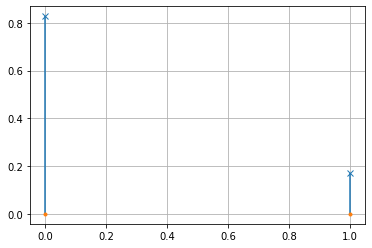

{'dist': {0.0: 0.8272962721364547, 1.0: 0.1727037278635452},
 'max': 1.0,
 'mean': 0.1727037278635452,
 'median': 0.0,
 'min': 0.0,
 'nunique': 2,
 'shape': (730, 1, 2835),
 'std': 0.37799093936968875}
____________________________________________________________


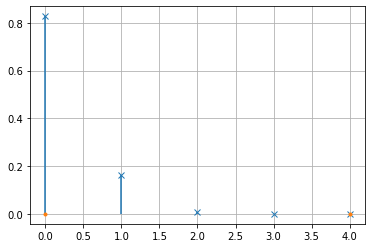

{'dist': {0.0: 0.8272962721364547,
          1.0: 0.1647826822256046,
          2.0: 0.007821023894083255,
          3.0: 9.90553501969027e-05,
          4.0: 9.663936604575874e-07},
 'max': 4.0,
 'mean': 0.18072576163900364,
 'median': 0.0,
 'min': 0.0,
 'nunique': 5,
 'shape': (730, 1, 2835),
 'std': 0.4053540888313317}
____________________________________________________________


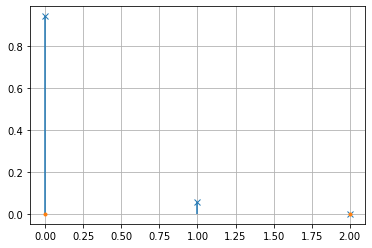

{'dist': {0.0: 0.9413732453915102,
          1.0: 0.0582614578048368,
          2.0: 0.00036529680365296805},
 'max': 2.0,
 'mean': 0.05899205141214273,
 'median': 0.0,
 'min': 0.0,
 'nunique': 3,
 'shape': (730, 1, 2835),
 'std': 0.2371551873555284}
____________________________________________________________


In [262]:
log_floor_crimes = np.floor(np.log2(1 + crimes))

conf.shaper_threshold = 0
conf.shaper_top_k = -1

shaper = Shaper(data=log_floor_crimes,
                conf=conf)
X_reg = shaper.squeeze(log_floor_crimes)  # crime counts scaled and discretised

X_clf = np.copy(X_reg) # crime=1 no_crime=0
X_clf[X_clf > 0] = 1

max_steps = -1


ha = HistoricAverage()
ha.fit(X_reg)
ha.max_steps = max_steps
X_ha = ha.transform(X_reg)


X_reg = X_reg[max_steps+1:]

X_clf = X_clf[max_steps+1:]

X_ha = X_ha[max_steps+1:]
X_ha = np.round(X_ha)  # ensures we still work in discrete values

sorted_indices = np.argsort(X_reg[:,0].mean(0))[::-1]

describe(X_clf,X_reg,X_ha)

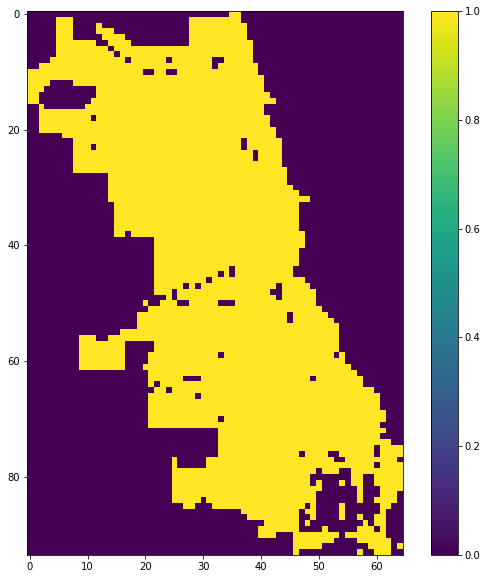

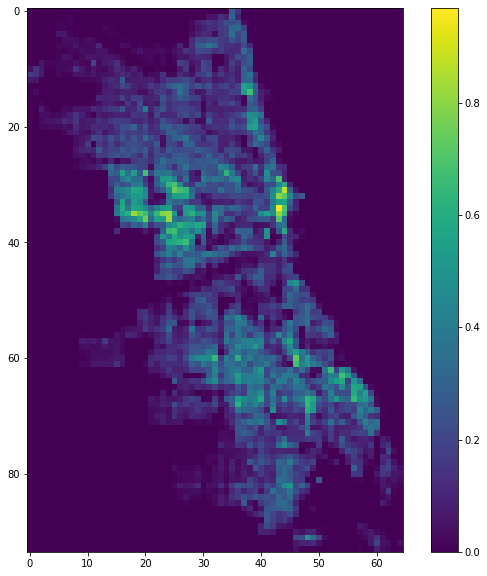

In [263]:
xx = X_clf

im(shaper.unsqueeze(xx).max(0)[0])
im(shaper.unsqueeze(xx).mean(0)[0])

In [264]:
np.prod(X_reg.shape)

2069550

In [265]:
mis = []

for i in range(len(sorted_indices)):
    p = 1- (i/(1+len(sorted_indices)))

    A = np.random.binomial(1,p,1300)
    X = np.expand_dims(A,axis=-1)
    y = A

    mi = mutual_info_classif(X,y,discrete_features=True)  # uses log not log2
    mis.append(mi) 

In [266]:
mis_t = []

for offset in range(1,30):
    mis = []
    for i in sorted_indices:
        X = np.reshape(X_clf[:-offset,0,i].flatten(),(-1,1))
        y = X_clf[offset:,0,i].flatten()

        mi = mutual_info_classif(X,y,discrete_features=True) # uses log not log2
        mis.append(mi)
    mis_t.append(mis)
    
mis_t = np.array(mis_t)[:,:,0]    

In [267]:
new_mis_grid = np.zeros((mis_t.shape[0]+1,mis_t.shape[1]+1))

new_mis_grid[0,1:] = mis_t.mean(0)
new_mis_grid[1:,0] = mis_t.mean(1)
new_mis_grid[1:,1:] = mis_t

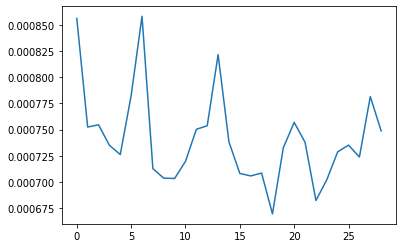

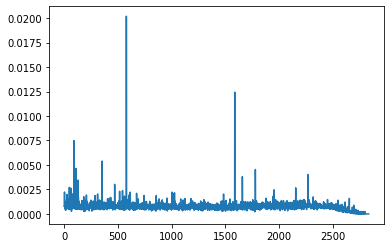

In [268]:
plt.plot(mis_t.mean(1))
plt.show()
plt.plot(mis_t.mean(0))
plt.show()

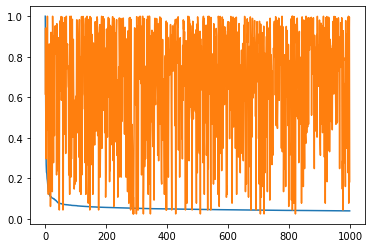

In [309]:
lim = 1000

plt.plot(norm_max(mis_t.mean(0)[top_mi[:lim]]))

plt.plot(norm_max(entropy(X_clf.mean(0)[0,top_mi[:lim]])))

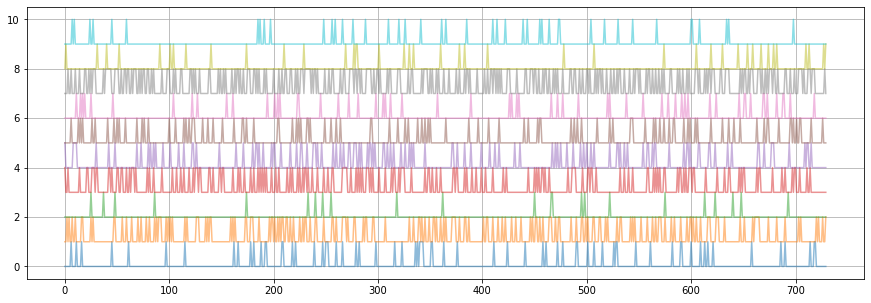

In [294]:
top_mi = np.argsort(mis_t.mean(0))[::-1][:]

plt.figure(figsize=(15,5))
for i in range(10):
    plt.plot(i+X_clf[:,0,top_mi[i]],alpha=0.5)
plt.grid()
plt.show()

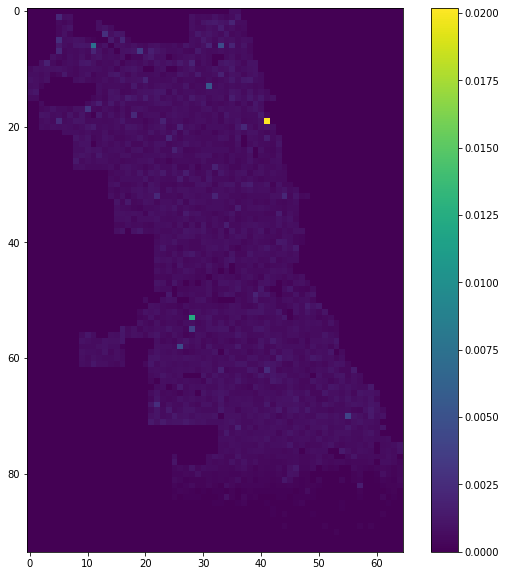

In [278]:
im(shaper.unsqueeze(np.expand_dims(mis_t,axis=1)).mean(0)[0])

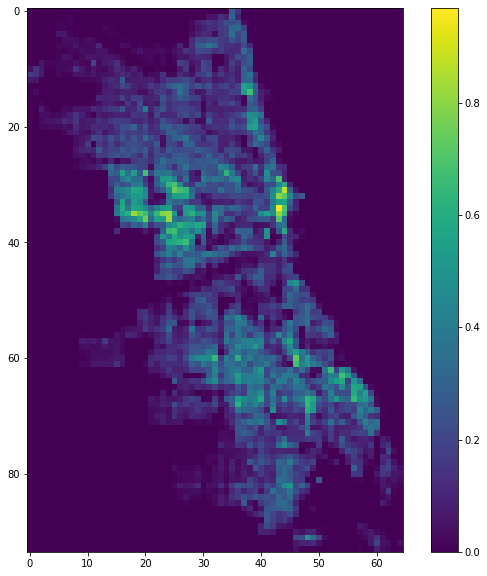

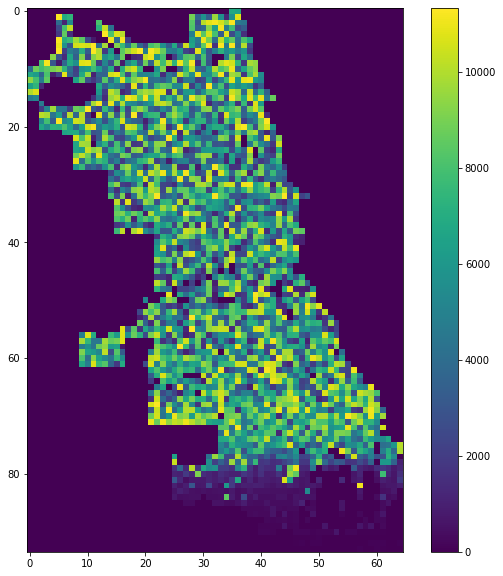

In [269]:
im(shaper.unsqueeze(X_clf).mean(0)[0])
for i in range(1):
    top_mi = np.argsort(mis_t.mean(0))[::-1][:]
    X_top_mi = np.zeros_like(X_clf)
    X_top_mi[:,0,top_mi] = np.arange(len(top_mi))[::-1]
    im(shaper.unsqueeze(4*X_top_mi+X_clf).mean(0)[0])

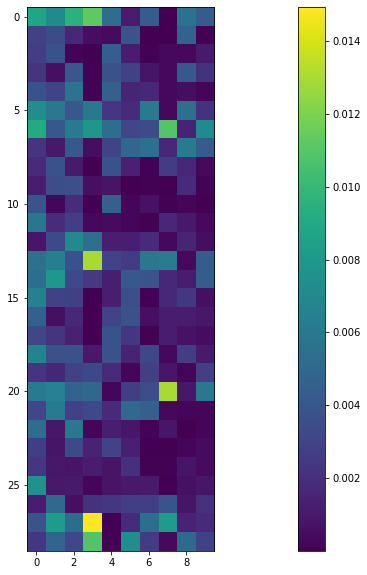

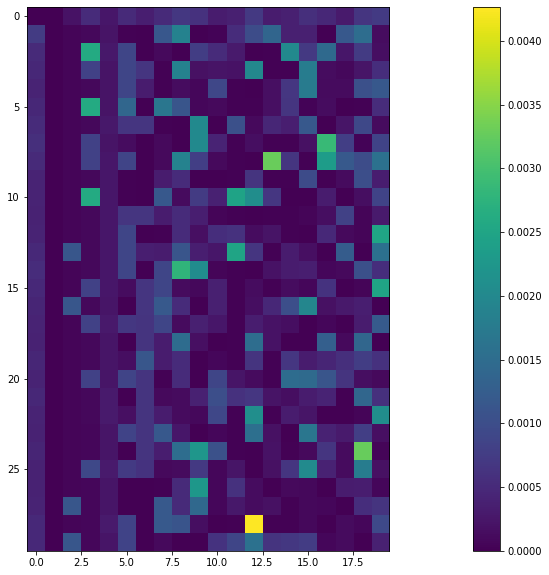

In [226]:
im(mis_t[:,top_mi],figsize=(30, 10),aspect=1)
im(new_mis_grid[:,:20],figsize=(30, 10),aspect=1)

In [159]:
def norm_sum(x):
    return x/np.sum(x)

def norm_max(x):
    return x/np.max(x)

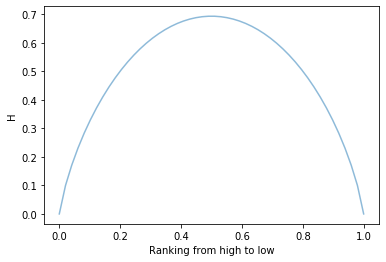

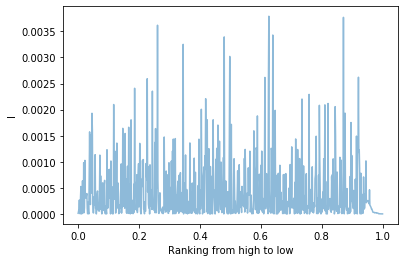

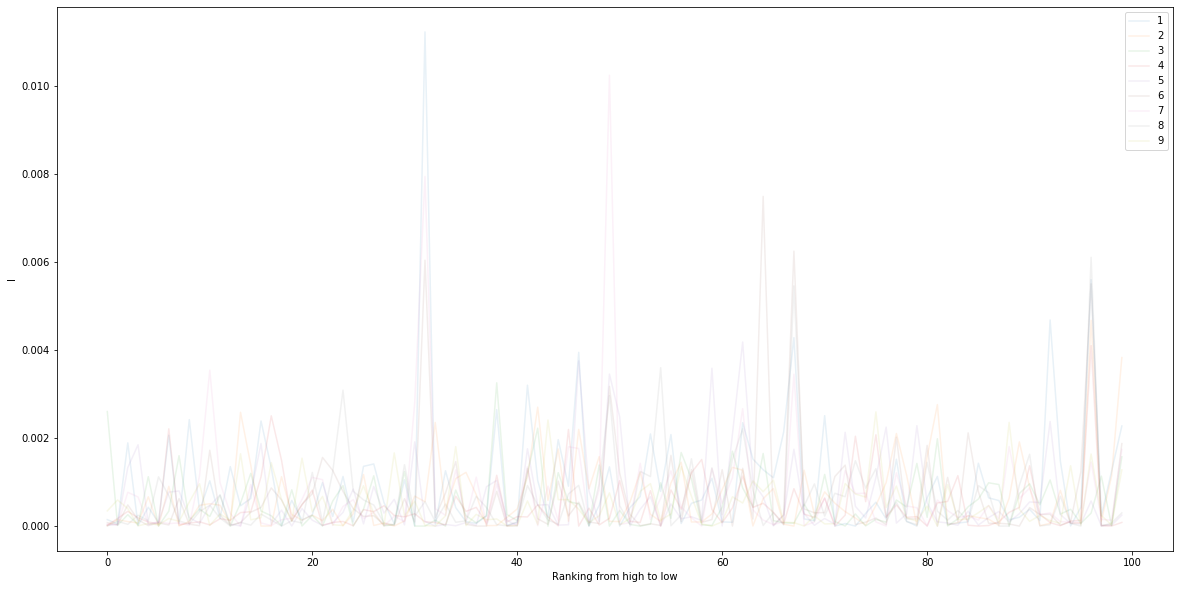

In [169]:
eps = 1e-8

ent = lambda p: p*np.log(p)*-1
x = np.linspace(1-eps, eps)
Hx = ent(1-x) + ent(x)

def plot(a,ylabel):
    plt.figure()
    plt.xlabel("Ranking from high to low")
    plt.ylabel(ylabel)
    plt.plot(np.arange(len(a))/(len(a)-1),a,alpha=.5)
    plt.show()

plot(Hx,"H")
plot(np.array(mis),"I")



plt.figure(figsize=(20,10))
plt.xlabel("Ranking from high to low")
plt.ylabel("I")

for k,v in mis_t.items():
    a = v[100:200]
#     plt.plot(np.arange(len(a))/(len(a)-1),a,alpha=.1,label=f"{k}")
    plt.plot(a,alpha=.1,label=f"{k}")    
plt.legend()    
plt.show()


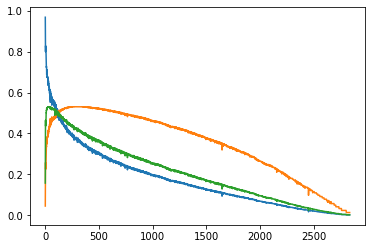

In [308]:
xx = X_clf.mean(0)[0][sorted_indices]

def entropy(x):
    return x*(-1)*np.log2(x)

plt.plot(xx)
plt.plot(entropy(xx))
plt.plot(entropy(1-xx))


In [45]:
X = np.reshape(X_ha[:-1].flatten(),(-1,1))
y = X_clf[1:].flatten()

mutual_info_classif(X,y,discrete_features=True)

array([0.11736102])

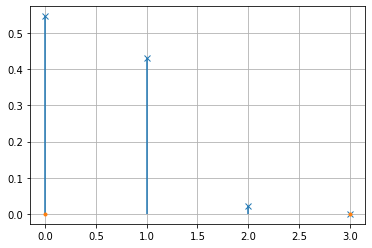

{'dist': {0.0: 0.546478635815175,
          1.0: 0.43147047341897937,
          2.0: 0.021440485485130244,
          3.0: 0.0006104052807154518},
 'max': 3.0,
 'mean': 0.47618266023138617,
 'median': 0.0,
 'min': 0.0,
 'nunique': 4,
 'shape': (1127120, 1),
 'std': 0.5440368893566866}
____________________________________________________________


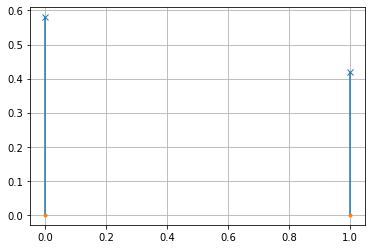

{'dist': {0.0: 0.5800970615373696, 1.0: 0.41990293846263044},
 'max': 1.0,
 'mean': 0.41990293846263044,
 'median': 0.0,
 'min': 0.0,
 'nunique': 2,
 'shape': (1127120,),
 'std': 0.49354276484726106}
____________________________________________________________


In [69]:
describe(X,y)

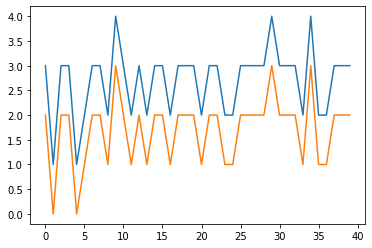

In [45]:
lim = 40
n = 30


plt.plot(1+X_ha[:lim,0,sorted_indices[n]])
plt.plot(X_reg[:lim,0,sorted_indices[n]])

fitted historic average: step (1) and max_steps (-1)


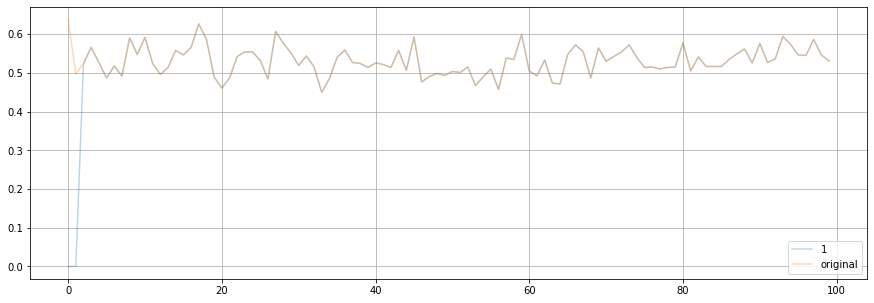

In [182]:
# historic average
ha = HistoricAverage(max_steps=7)
ha.fit(X_reg)

lim = 100

plt.figure(figsize=(15,5))

for max_steps in [1]:
    ha.max_steps = max_steps
    X_ha = ha.transform(X_reg)
    plt.plot(X_ha.mean(-1)[:lim],alpha=0.3,label=f"{max_steps}")

plt.plot(X_reg.mean(-1)[:lim],alpha=0.3,label="original")
plt.grid()
plt.legend()
plt.show()

In [185]:
np.sum(X_reg[10:]-X_ha[10:])



0.0

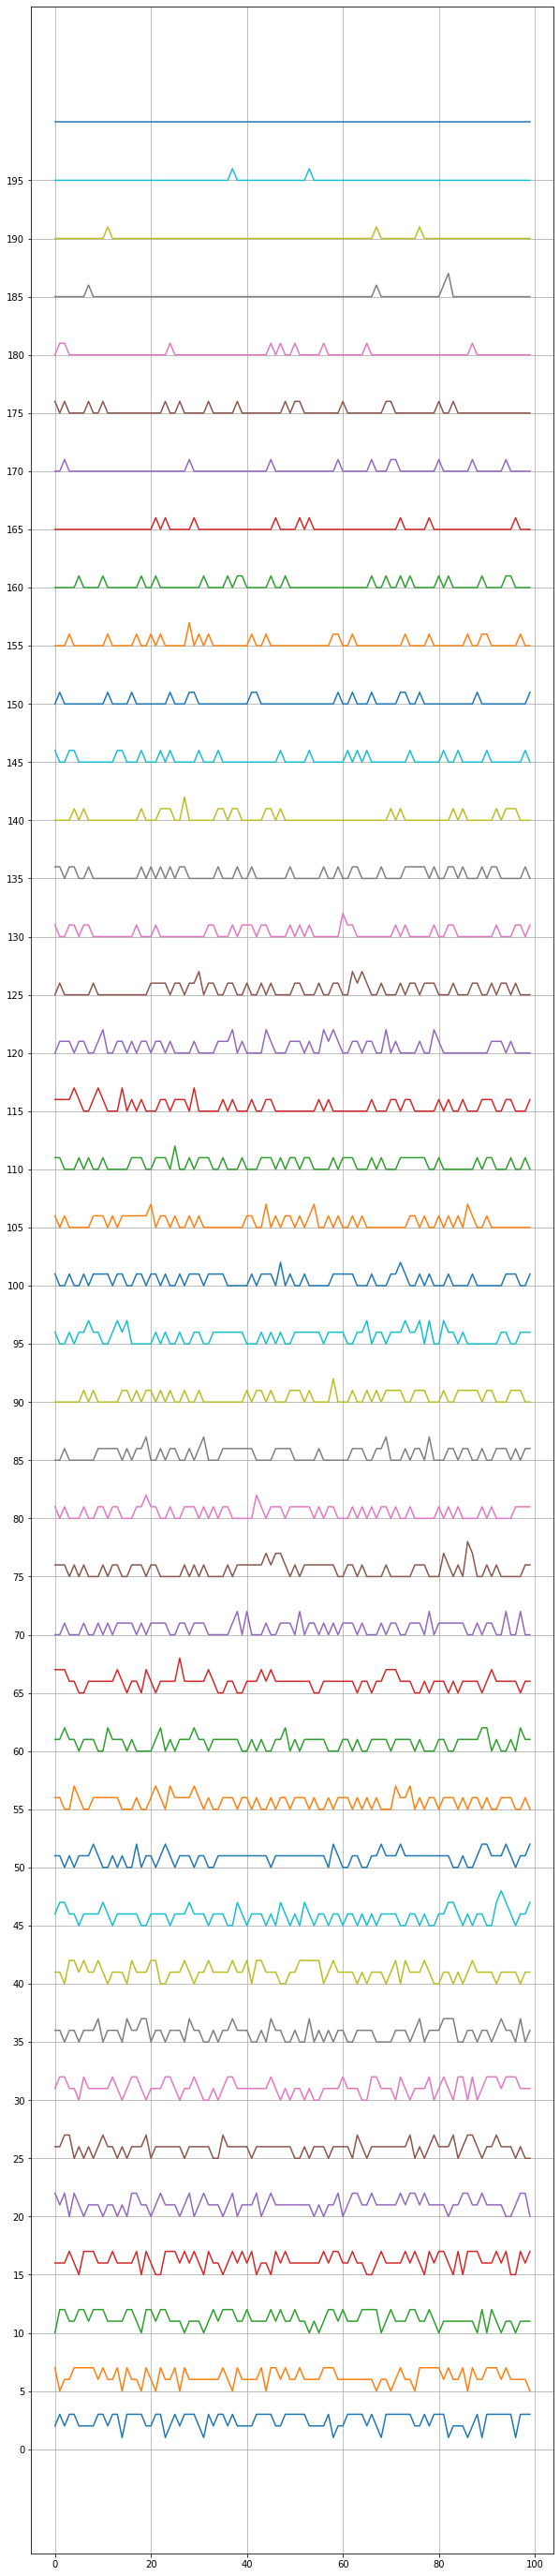

In [35]:
# construct X and y for the mi calculations
max_offset = np.max(X_reg)

plt.figure(figsize=(10,50))
for offset, index in enumerate(sorted_indices[::len(sorted_indices)//40]):
    x = X_reg[:100,0,index]
    plt.plot(x+offset*max_offset)
plt.yticks(np.arange(offset)*max_offset)    
plt.grid()
plt.show()


In [37]:
# shaper can filer out dead cells based on the variance?
conf.data_path

'./data/processed/T24H-X850M-Y880M_2013-01-01_2017-01-01/'

In [87]:
def plot_seq(a):
    plt.figure(figsize=(15,5))
    plt.plot(a)
    plt.grid()
    plt.show()

In [193]:
X_stack = []
y_stack = []

for i in sorted_indices[:]:#range(len(sorted_indices)):
    seq = X_reg[:,0,i]

    seq_len = 100

    sequences = sequencify(seq,seq_len=seq_len+1)  # shape -> (N-seq_len, seq_len)
    X, y = sequences[:,:], np.copy(sequences[:,-1])
    # add al zero column
    n_samples,n_feats = X.shape
    new_X = np.zeros((n_samples,n_feats+2))
    new_X[:, 2:] = X
    new_X[:, 0] = np.random.randint(0, len(set(X.flatten())), size=len(X))

    X = new_X
    y[y > 0] = 1
    
    X_stack.append(X)
    y_stack.append(np.reshape(y,(-1,1)))
    
X = np.vstack(X_stack)
y = np.vstack(y_stack)[:,0]    

In [194]:
pshape(X,y)
mi = mutual_info_classif(X,y,discrete_features=True)
# mi = mutual_info_regression(X,y)
mi = mi/np.max(mi)

(1041428, 103)
(1041428,)


./data/processed/T24H-X850M-Y880M_2013-01-01_2017-01-01/


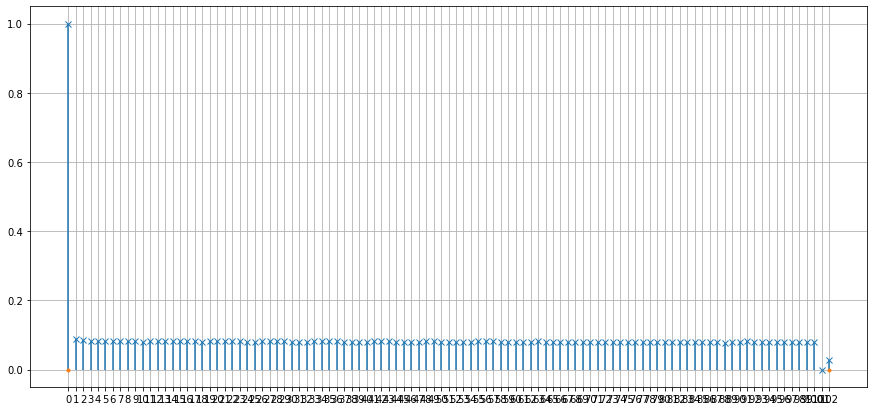

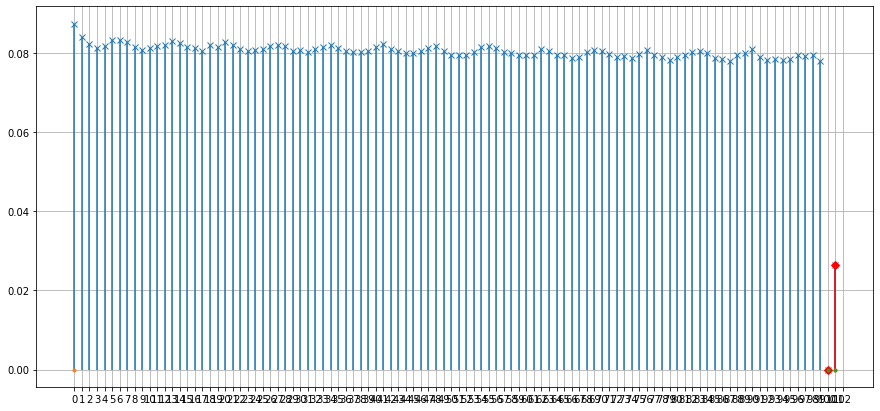

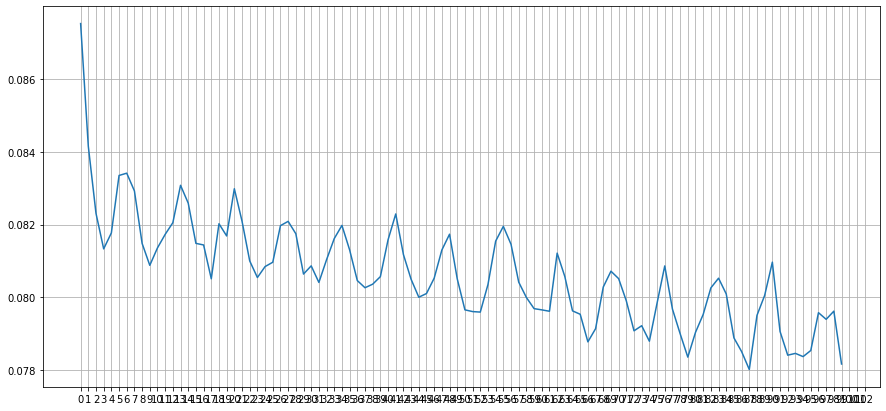

In [195]:
print(conf.data_path)

plt.figure(figsize=(15,7))
plt.stem(mi[::-1], use_line_collection=True,markerfmt="x",basefmt=".")
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()

plt.figure(figsize=(15,7))
plt.stem(mi[:-1][::-1], use_line_collection=True,markerfmt="x",basefmt=".")
plt.stem([len(mi)-3,len(mi)-2],mi[:-1][::-1][-2:], use_line_collection=True,linefmt="r",markerfmt="rD",basefmt=".")
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()

print()
plt.figure(figsize=(15,7))
plt.plot(mi[2:-1][::-1])
plt.xticks(np.arange(len(mi)))
plt.grid()
plt.show()


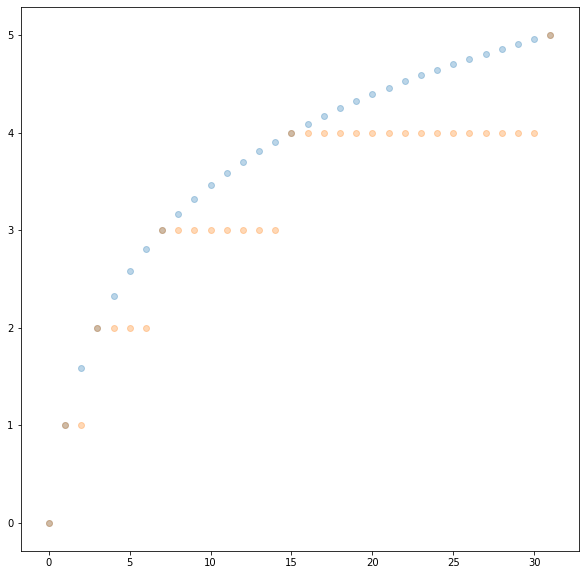

In [104]:

x = np.arange(32)
x_log = np.log2(1 + x)
x_log_round = np.floor(x_log)

plt.figure(figsize=(10,10))
# plt.scatter(x,x,alpha=.3,label="x")
plt.scatter(x,x_log,alpha=.3,label="log(x)")
plt.scatter(x,x_log_round,alpha=.3,label="round(log(x))")
plt.show()
